In [1]:
library(igraph)
library(ggnetwork)
library(tidyverse)
library(cowplot)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

rslt <- '../results/'


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default 

# Mappings

In [2]:
path <- '~/projects/waffles/results/fuma_mapping/'

maps <- bind_rows(read_tsv(paste0(path, 'physical_mapping.tsv'), col_types = 'cccc') %>% mutate(map = 'Positional'),
                  read_tsv(paste0(path, 'chromatin_interaction_mapping.tsv'), col_types = 'cccc') %>% mutate(map = 'Chromatin'),
                  read_tsv(paste0(path, 'eqtl_mapping.tsv'), col_types = 'ccc') %>% mutate(map = 'eQTL')) %>%
    mutate(map = factor(map, levels = c('Positional', 'eQTL', 'Chromatin')))

In [3]:
select(maps, map, rsID, ensg) %>% unique %>% .$map %>% table

.
Positional       eQTL  Chromatin 
    174879     411120    2394589 

In [4]:
# library(ggupset)

# select(maps, map, rsID, ensg) %>% 
#     unique %>%
#     group_by(rsID, ensg) %>%
#     summarize(kk = paste(map, collapse = '-')) 
# %>%
#     ggplot(aes(x = map)) +
#         geom_bar() +
#         scale_x_upset()

`summarise()` regrouping output by 'ensg' (override with `.groups` argument)

`summarise()` regrouping output by 'ensg' (override with `.groups` argument)

`summarise()` regrouping output by 'ensg' (override with `.groups` argument)



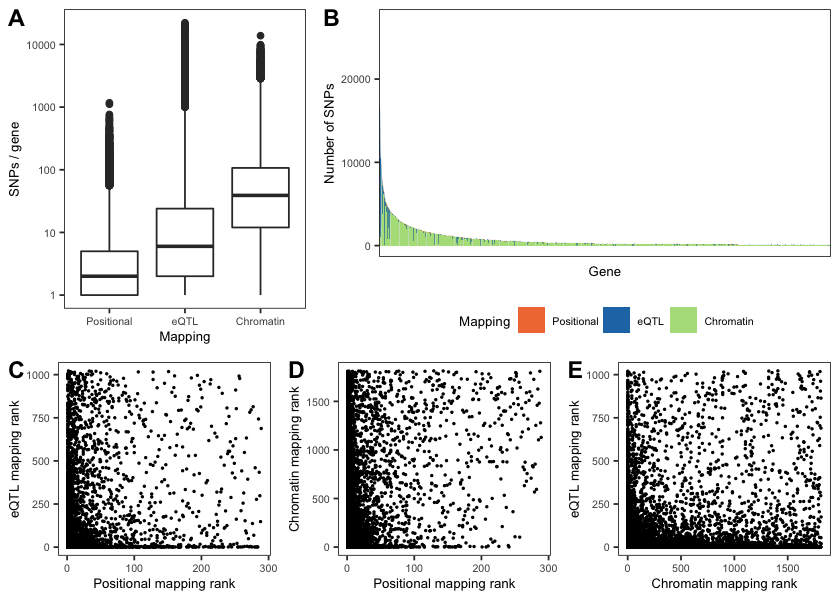

In [5]:
snpsXgene_plt <- group_by(maps, ensg, map) %>%
    summarize(n = n()) %>%
    ggplot(aes(x = map, y = n)) +
        geom_boxplot() +
        labs(y = 'SNPs / gene', x = 'Mapping') +
        theme_bw() +
        scale_y_log10() +
        theme(text = element_text(size = 8)) +
        theme_transparent

most_described <- group_by(maps, ensg, map) %>%
    summarize(n = n()) %>%
    arrange(desc(n)) %>%
    ungroup %>%
    spread(map, n) %>%
    replace(is.na(.), 0) %>%
    mutate(n = Positional + eQTL + Chromatin) %>%
    arrange(desc(n)) %>%
    mutate(ensg = factor(ensg, levels = unique(ensg))) %>%
    filter(n > 100) %>%
    gather('map','counts',-ensg,-n) %>%
    mutate(map = factor(map, levels = c('Positional', 'eQTL', 'Chromatin'))) %>%
    ggplot(aes(x = ensg, y = counts, fill = map)) +
        geom_bar(stat = 'identity') +
        theme_bw() +
        labs(x = 'Gene', y = 'Number of SNPs', fill = 'Mapping') +
        scale_fill_manual(values = c('Positional' = '#f07b3f',
                                     'eQTL' = '#1f78b4',
                                     'Chromatin' = '#b2df8a')) +
        theme(axis.text.x = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              legend.position = 'bottom',
              text = element_text(size = 8),
              axis.ticks.x = element_blank()) +
#         scale_y_log10() +
        theme_transparent

rank_maps <- group_by(maps, ensg, map) %>%
    summarize(n = n()) %>%
    arrange(desc(n)) %>%
    ungroup %>%
    spread(map, n) %>%
    replace(is.na(.), 0) %>%
    mutate(Positional_rnk = dense_rank(Positional),
           eQTL_rnk = dense_rank(eQTL),
           Chromatin_rnk = dense_rank(Chromatin))

phy_vs_eqtl <- ggplot(rank_maps, aes(Positional_rnk, eQTL_rnk)) +
    geom_point(size = .3) +
    theme_bw() +
    labs(x = 'Positional mapping rank', y = 'eQTL mapping rank') +
    theme(text = element_text(size = 8)) +
    theme_transparent

phy_vs_chr <- ggplot(rank_maps, aes(Positional_rnk, Chromatin_rnk)) +
    geom_point(size = .3) +
    theme_bw() +
    labs(x = 'Positional mapping rank', y = 'Chromatin mapping rank') +
    theme(text = element_text(size = 8)) +
    theme_transparent

chr_vs_eqtl <- ggplot(rank_maps, aes(Chromatin_rnk, eQTL_rnk)) +
    geom_point(size = .3) +
    theme_bw() +
    labs(x = 'Chromatin mapping rank', y = 'eQTL mapping rank') +
    theme(text = element_text(size = 8)) +
    theme_transparent

options(repr.plot.width=7, repr.plot.height=5)
plot_grid(plot_grid(snpsXgene_plt, most_described, rel_widths = c(.6, 1), labels = c('A', 'B')),
          plot_grid(phy_vs_eqtl, phy_vs_chr, chr_vs_eqtl, ncol = 3, labels = c('C','D','E')),
          nrow = 2, rel_heights = c(1,.7))
ggsave(filename = 'fig/mappings_per_gene.pdf', width=7, height=5, bg = "transparent")
ggsave(filename = 'fig/mappings_per_gene.png', width=7, height=5, bg = "transparent")

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


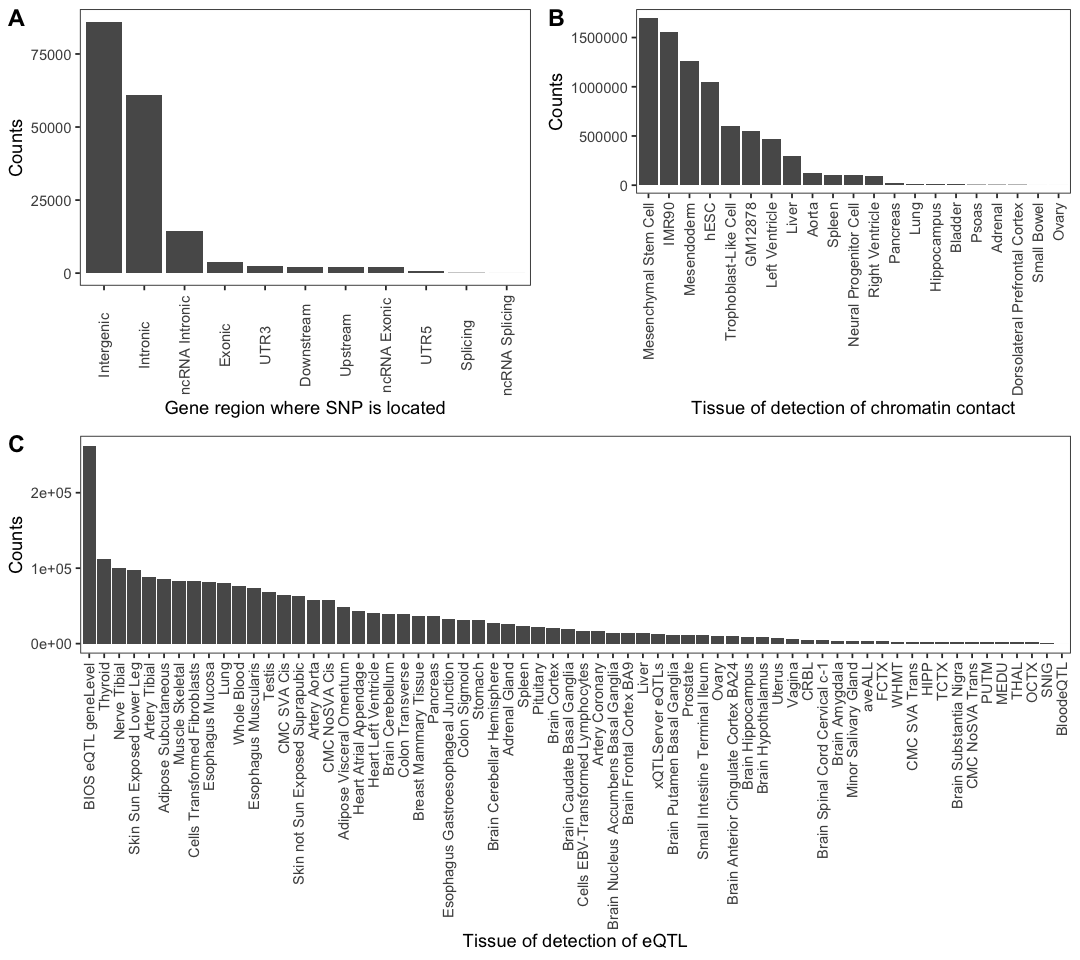

In [6]:
positionalRegion_plt <- filter(maps, map == 'Positional') %>%
    group_by(annot) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(annot = gsub('_', ' ', annot),
           annot = tools::toTitleCase(annot),
           annot = factor(annot, levels = unique(annot))) %>%
    ggplot(aes(x = annot, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene region where SNP is located', y = 'Counts') +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = .5)) +
        theme_transparent

eqtlTissue_plt <- filter(maps, map == 'eQTL') %>%
    group_by(tissue) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(tissue = gsub('_', ' ', tissue),
           tissue = tools::toTitleCase(tissue),
           tissue = factor(tissue, levels = unique(tissue))) %>%
    ggplot(aes(x = tissue, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Tissue of detection of eQTL', y = 'Counts') +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = .5, hjust = 1)) +
        theme_transparent

chrTissue_plt <- filter(maps, map == 'Chromatin') %>%
    group_by(tissue) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(tissue = gsub('_', ' ', tissue),
           tissue = tools::toTitleCase(tissue),
           tissue = factor(tissue, levels = unique(tissue))) %>%
    ggplot(aes(x = tissue, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Tissue of detection of chromatin contact', y = 'Counts') +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = .5, hjust = 1)) +
        theme_transparent

options(repr.plot.width=9, repr.plot.height=8)
plot_grid(plot_grid(positionalRegion_plt, chrTissue_plt, labels = c('A','B')), 
          eqtlTissue_plt, 
          labels = c(NA,'C'), nrow = 2, rel_heights = c(.8, 1))
ggsave(filename = 'fig/tissue_origin.pdf', 
       width=9, height=8, bg = "transparent")

# Network stats

In [7]:
snp_stats <- function(path) {
    g <- read_csv(paste0(rslt, path), col_types = 'ccdccc') %>%
        select(SNP_1, SNP_2) %>%
        unique %>%
        graph_from_data_frame(directed = FALSE) %>%
        simplify
    
    c(nodes = length(V(g)),
      edges = length(E(g)),
      avg_degree = mean(degree(g)),
      components = components(g)$no,
      largest_component = max(components(g)$csize))
}

snp_stats <- bind_cols(Standard = snp_stats('noFilter/sign_SNPPairs.txt'),
                       Positional = c(0, 0, NA, NA, NA),
                       Chromatin = snp_stats('withBiofilter_filter/chromatin/sign_SNPPairs.txt'),
                       eQTL = snp_stats('withBiofilter_filter/eqtl/sign_SNPPairs.txt'))
rownames(snp_stats) <- c('Nodes', 'Edges', 'Avg degree','Components', 'Largest component')
snp_stats

Warning message:
“Setting row names on a tibble is deprecated.”


,Standard,Positional,Chromatin,eQTL
,<dbl>,<dbl>,<dbl>,<dbl>
Nodes,55.000000,0,20.0,46.000000
Edges,57.000000,0,19.0,64.000000
Avg degree,2.072727,NA,1.9,2.782609
Components,12.000000,NA,5.0,6.000000
Largest component,25.000000,NA,11.0,17.000000


In [8]:
gene_stats <- function(path) {
    g <- read_csv(paste0(rslt, path), col_types = 'cdccd') %>%
        separate(genePairs_names, into = c('gene_a', 'gene_b'), sep = ' ') %>%
        select(gene_a, gene_b) %>%
        unique %>%
        graph_from_data_frame(directed = FALSE)
    
    c(nodes = length(V(g)),
      edges = length(E(g)),
      avg_degree = mean(degree(g)),
      components = components(g)$no,
      largest_component = max(components(g)$csize))
}

gene_stats <- bind_cols(Standard = gene_stats('noFilter/sign_GenePairs.txt'),
                        Positional = c(0, NA, NA, NA, NA),
                        Chromatin = gene_stats('withBiofilter_filter/chromatin/sign_GenePairs_withoutThreshold.txt'),
                        eQTL = gene_stats('withBiofilter_filter/eqtl/sign_GenePairs_withoutThreshold.txt'))
rownames(gene_stats) <- c('Nodes', 'Edges', 'Avg degree','Components', 'Largest component')
gene_stats

Warning message:
“Setting row names on a tibble is deprecated.”


,Standard,Positional,Chromatin,eQTL
,<dbl>,<dbl>,<dbl>,<dbl>
Nodes,29.000000,0,10,11.000000
Edges,26.000000,NA,5,7.000000
Avg degree,1.793103,NA,1,1.272727
Components,8.000000,NA,5,5.000000
Largest component,6.000000,NA,2,3.000000


# Figures

`summarise()` regrouping output by 'uniq_snp_id' (override with `.groups` argument)

`summarise()` regrouping output by 'uniq_gene_id' (override with `.groups` argument)



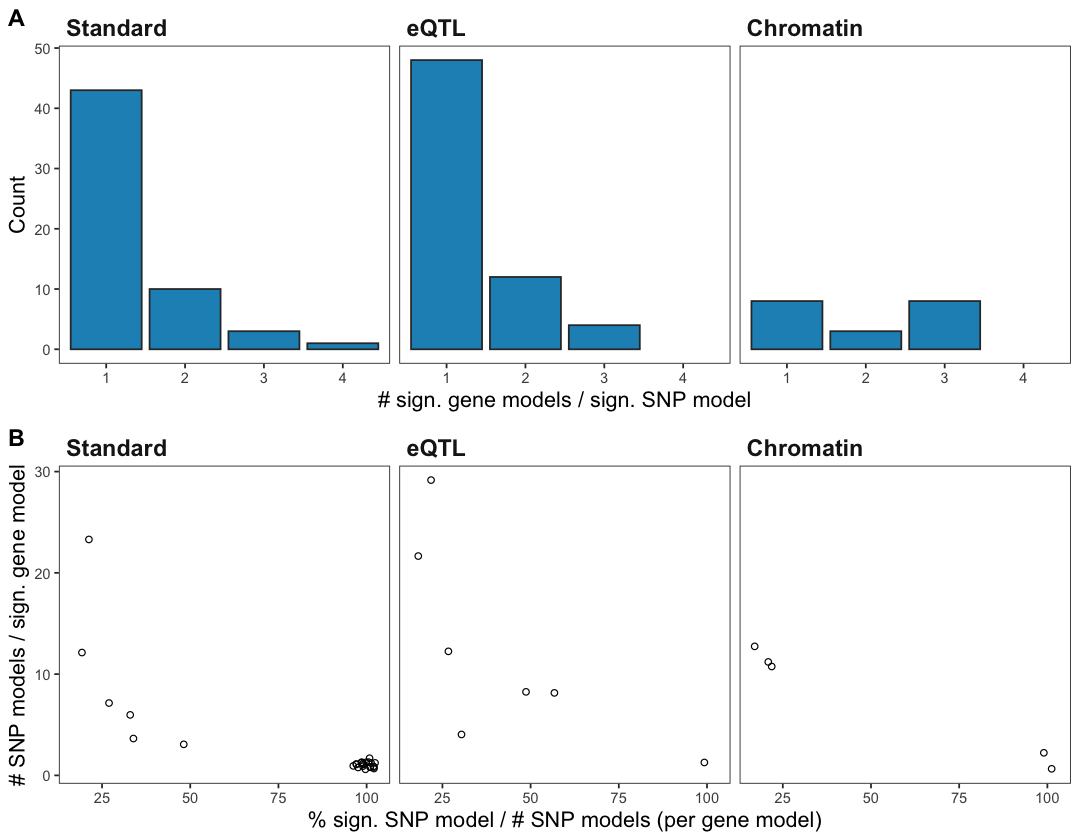

In [9]:
make_key <- function(a1, a2) {
    cbind(a1, a2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_')
}

get_mapped_genes <- function(genes, snps) {

    uniq_snp2gene <- read_csv(paste0(rslt, genes), col_types = 'cdccd') %>%
        separate_rows(SNP1, sep = ' ') %>%
        separate_rows(SNP2, sep = ' ') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_gene_id = make_key(gene1, gene2),
               uniq_snp_id = make_key(SNP1, SNP2),
               sign_gene = TRUE) %>%
        select(uniq_gene_id, uniq_snp_id, sign_gene) %>%
        unique

    uniq_snp <- read_csv(paste0(rslt, snps), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = make_key(SNP_1, SNP_2),
               uniq_gene_id = make_key(gene1, gene2),
               sign_snp = TRUE) %>%
        select(uniq_gene_id, uniq_snp_id, sign_snp) %>%
        unique
    
    full_join(uniq_snp, uniq_snp2gene, by = c("uniq_gene_id", "uniq_snp_id")) %>%
        mutate(sign_gene = ifelse(is.na(sign_gene), FALSE, TRUE),
               sign_snp = ifelse(is.na(sign_snp), FALSE, TRUE))
    
}

maps <- bind_rows(get_mapped_genes('noFilter/sign_GenePairs.txt', 'noFilter/sign_SNPPairs.txt') %>% mutate(exp = 'Standard'),
                  get_mapped_genes('withBiofilter_filter/chromatin/sign_GenePairs_withoutThreshold.txt',
                                   'withBiofilter_filter/chromatin/sign_SNPPairs.txt') %>% mutate(exp = 'Chromatin'),
                  get_mapped_genes('withBiofilter_filter/eqtl/sign_GenePairs_withoutThreshold.txt',
                                   'withBiofilter_filter/eqtl/sign_SNPPairs.txt') %>% mutate(exp = 'eQTL')) %>%
    select(uniq_gene_id, uniq_snp_id, sign_gene, sign_snp, exp) %>%
    mutate(exp = factor(exp, levels = c('Standard', 'eQTL', 'Chromatin')))

snp2gene_plt <- maps %>%
    filter(sign_snp & sign_gene) %>%
    group_by(uniq_snp_id, exp) %>%
    summarise(n = factor(as.character(n()), levels = as.character(seq(1, 9)))) %>%
    ggplot(aes(x = n)) +
        geom_bar(stat = 'count', color = 'gray20', fill = '#1d91c0') +
        labs(x = '# sign. gene models / sign. SNP model', y = 'Count') +
        facet_grid(. ~ exp) +
        scale_fill_manual(values = c('Yes' = '#1d91c0', 'No' = 'gray80')) +
        theme_bw() +
        theme(strip.background = element_blank(),
              strip.text = element_text(size = 14, face = "bold", hjust=0),
              axis.title = element_text(size = 13),
              legend.position = 'bottom') +
        theme_transparent

gene2snp_plt <- maps %>%
    filter(sign_gene) %>%
    group_by(uniq_gene_id, exp) %>%
    summarise(sign_snps = sum(sign_snp),
              pc_sign_snps = 100 * sign_snps / n()) %>%
    ggplot(aes(x = pc_sign_snps, y = sign_snps)) +
        geom_jitter(shape = 21, color = 'black', width = 4) +
        labs(x = '% sign. SNP model / # SNP models (per gene model)', 
             y = '# SNP models / sign. gene model',
             size = 'Number of gene models') +
        facet_grid(. ~ exp) +
#         scale_x_continuous(limits = c(0, NA)) +
        theme_bw() +
        theme(strip.background = element_blank(),
              strip.text = element_text(size = 14, face = "bold", hjust=0),
              axis.title = element_text(size = 13),
              legend.position = 'bottom') +
        theme_transparent

options(repr.plot.width=9, repr.plot.height=7)
plot_grid(snp2gene_plt, gene2snp_plt, nrow = 2, labels = c('A', 'B'))
ggsave(filename = 'fig/sign_snps_per_gene_and_viceversa.pdf', 
       width=9, height=7, bg = "transparent")

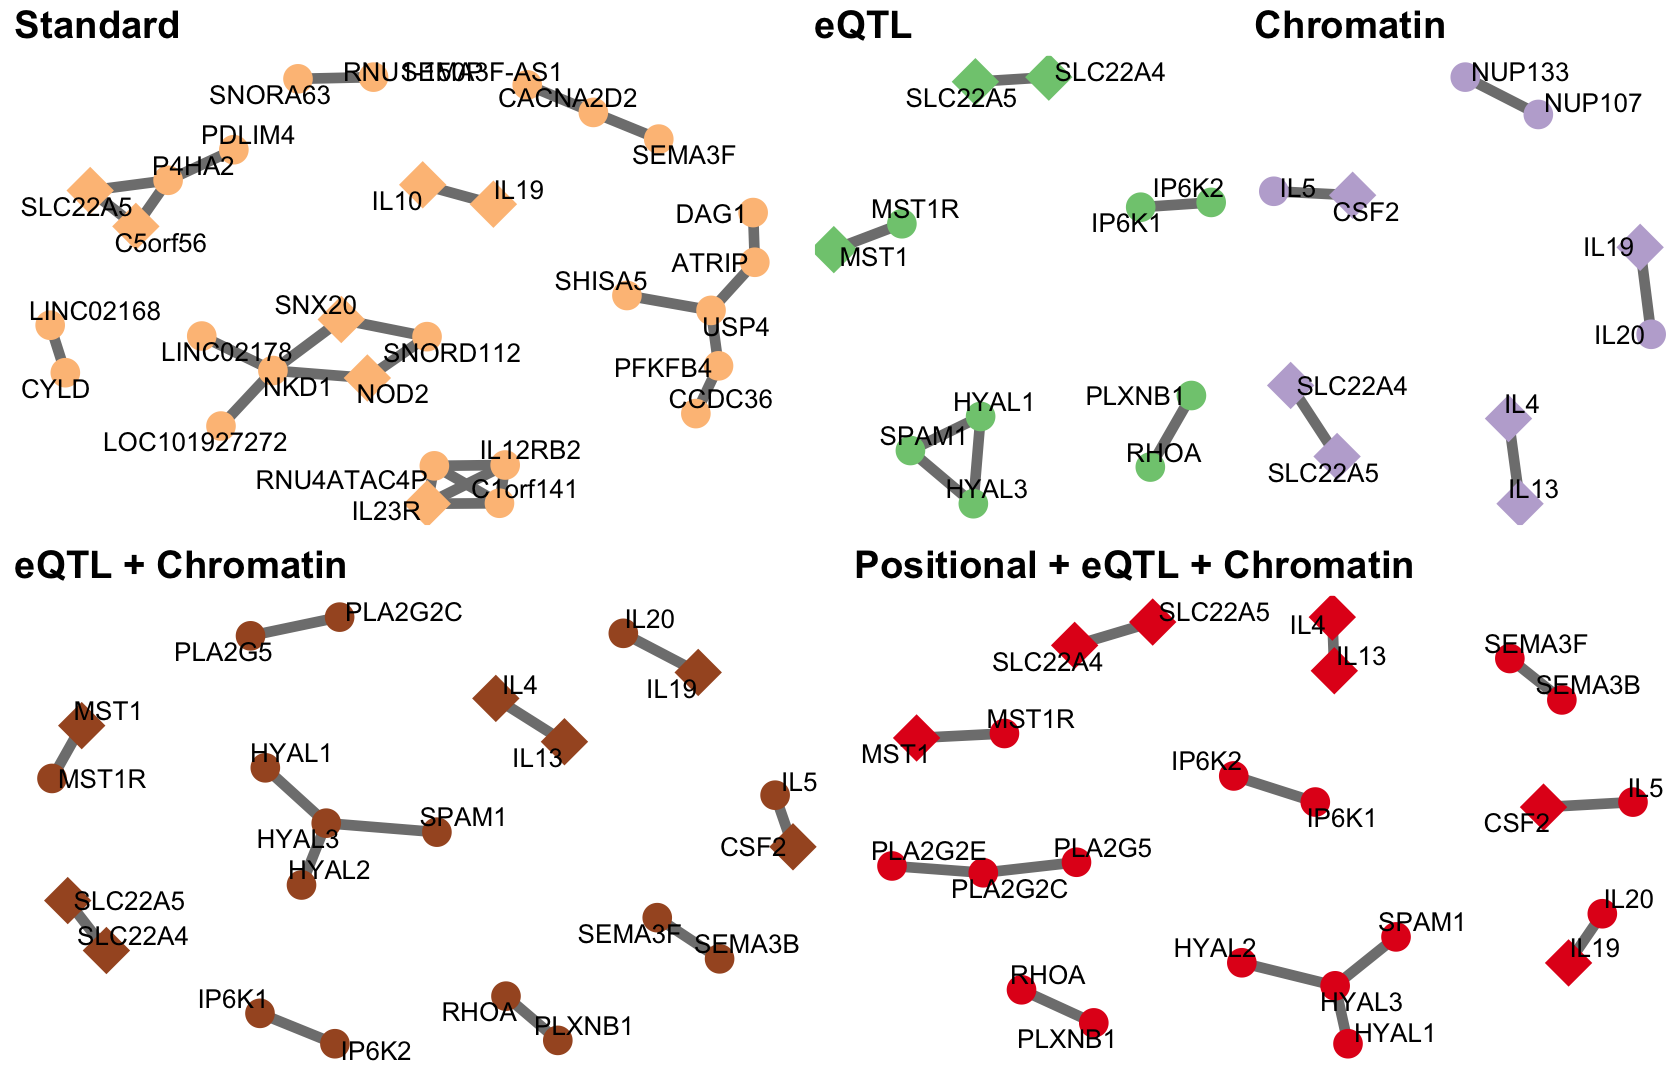

In [10]:
plot_genes <- function(path, tag, color) {

    read_csv(paste0(rslt, path), col_types = 'cdccd') %>%
        separate(genePairs_names, into = c('gene_a', 'gene_b'), sep = ' ') %>%
        select(gene_a, gene_b, MinP) %>%
        graph_from_data_frame(directed = FALSE) %>%
        ggnetwork %>%
        mutate(ibd = name %in% ibd_genes) %>%
        ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
            geom_edges(color = 'gray50', size = 3) +
            geom_nodes(aes(size = ibd, shape = ibd), color = color) +
            geom_nodetext_repel(aes(label = name), size = 5.5) +
            theme_blank() +
            theme(legend.position = 'none') +
            theme(plot.title = element_text(size = 23, face = "bold")) +
            theme_transparent +
            ggtitle(tag) + 
            scale_size_manual(values = c('TRUE' = 13, 'FALSE' = 8)) +
            scale_shape_manual(values = c('TRUE' = 18, 'FALSE' = 16))

}

ibd_genes <- read_tsv('../data/C0021390_disease_gda_summary.tsv',
                      col_types = cols(.default = col_character()))$Gene

genes_eqtl <- plot_genes('withBiofilter_filter/eqtl/sign_GenePairs_withoutThreshold.txt', 'eQTL', '#7fc97f')
genes_chr <- plot_genes('withBiofilter_filter/chromatin/sign_GenePairs_withoutThreshold.txt', 'Chromatin', '#beaed4')
genes_noFilter <- plot_genes('noFilter/sign_GenePairs.txt', 'Standard', '#fdc086')
genes_eqtl_chrom <- plot_genes('withBiofilter_filter/eqtl_chrom/sign_GenePairs_withoutThreshold.txt', 'eQTL + Chromatin', '#a65628')
genes_eqtl_chrom_phys <- plot_genes('withBiofilter_filter/eqtl_chrom_phys/sign_GenePairs_withoutThreshold.txt', 'Positional + eQTL + Chromatin', '#e31a1c')

options(repr.plot.width=14, repr.plot.height=9)
plot_grid(plot_grid(genes_noFilter, genes_eqtl, genes_chr, ncol = 3, rel_widths = c(1, .55, .55)),
          plot_grid(genes_eqtl_chrom, genes_eqtl_chrom_phys, ncol = 2),
          nrow = 2)

ggsave(filename = 'fig/gene_networks.pdf', width=14, height=9, bg = "transparent")

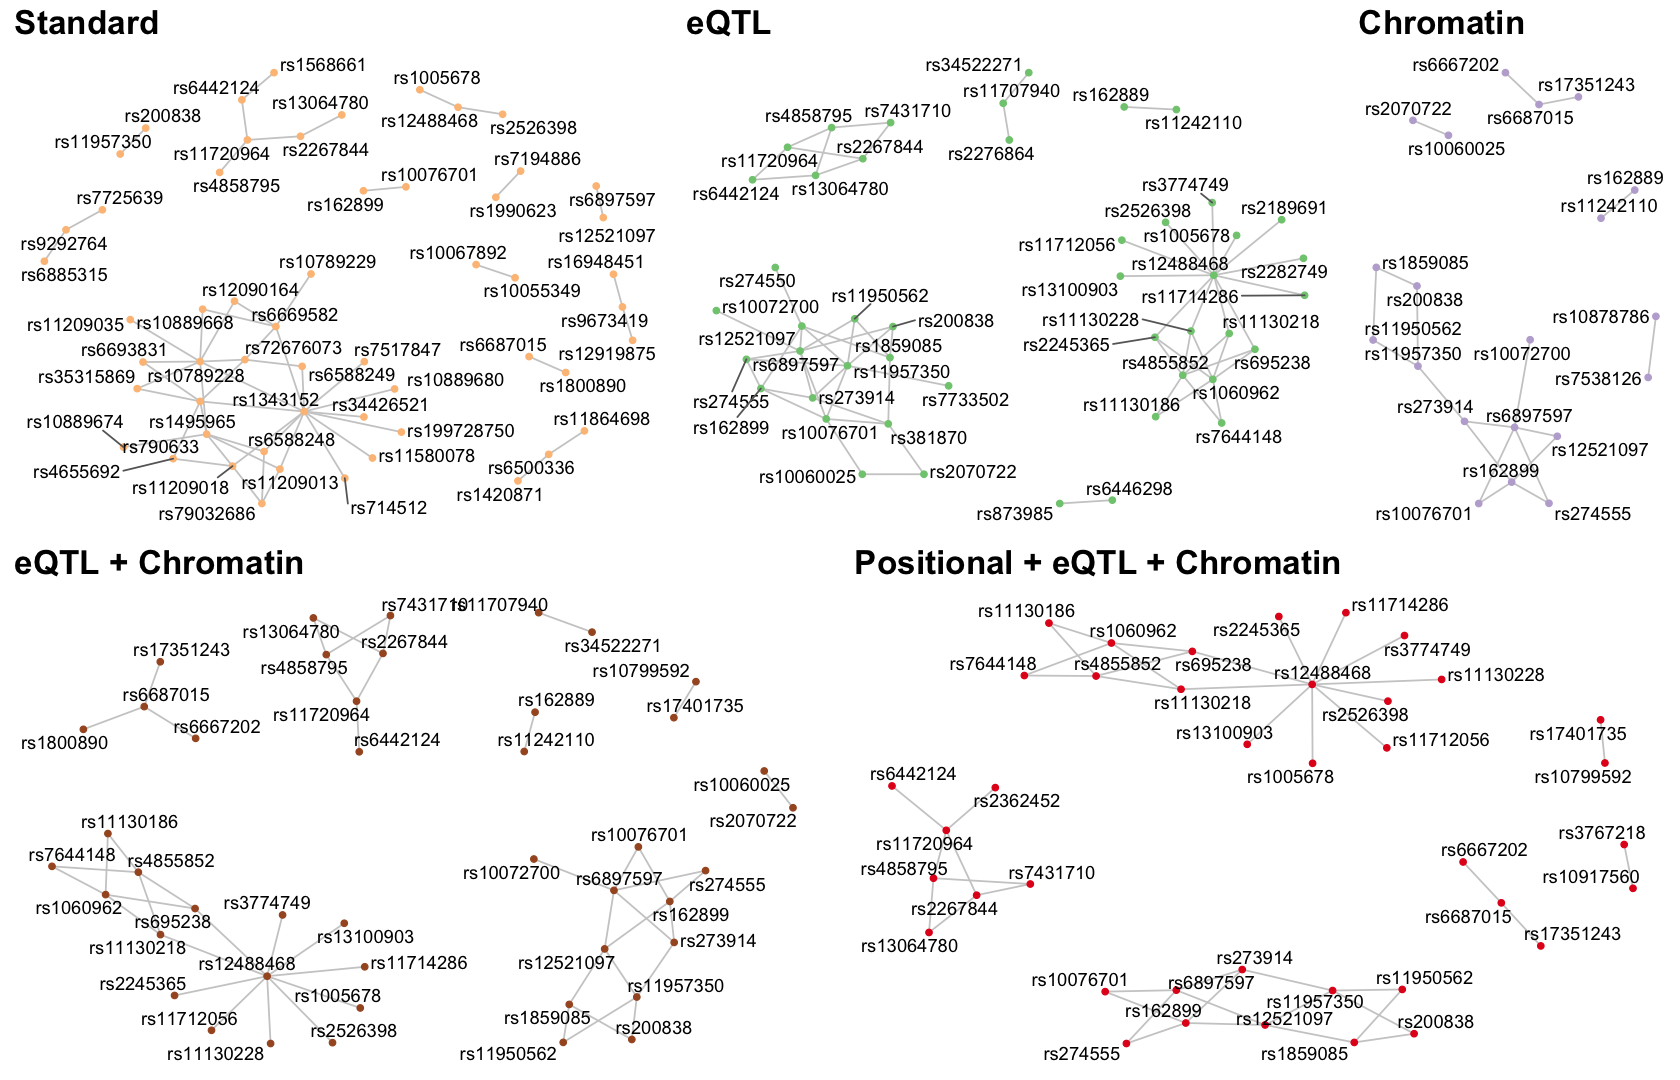

In [11]:
plot_genes <- function(path, tag, color) {

    read_csv(paste0(rslt, path), col_types = 'ccdccc') %>%
    select(SNP_1, SNP_2) %>%
    unique %>%
    graph_from_data_frame(directed = FALSE) %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray80') +
        geom_nodes(color = color) +
        geom_nodetext_repel(aes(label = name)) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        ggtitle(tag) + 
        theme(plot.title = element_text(size = 20, face = "bold")) +
        theme_transparent

}

snp_eqtl <- plot_genes('withBiofilter_filter/eqtl/sign_SNPPairs.txt', 'eQTL', '#7fc97f')
snp_chr <- plot_genes('withBiofilter_filter/chromatin/sign_SNPPairs.txt', 'Chromatin', '#beaed4')
snp_noFilter <- plot_genes('noFilter/sign_SNPPairs.txt', 'Standard', '#fdc086')
genes_eqtl_chrom <- plot_genes('withBiofilter_filter/eqtl_chrom/sign_SNPPairs.txt', 'eQTL + Chromatin', '#a65628')
genes_eqtl_chrom_phys <- plot_genes('withBiofilter_filter/eqtl_chrom_phys/sign_SNPPairs.txt', 'Positional + eQTL + Chromatin', '#e31a1c')

options(repr.plot.width=14, repr.plot.height=9)
plot_grid(plot_grid(snp_noFilter, snp_eqtl, snp_chr, ncol = 3, rel_widths = c(1, 1, .5)),
          plot_grid(genes_eqtl_chrom, genes_eqtl_chrom_phys, ncol = 2),
          nrow = 2)

ggsave(filename = 'fig/snp_networks.pdf', width=14, height=9, bg = "transparent")

In [12]:
artifact_clusters <- function(path, tag) {
    
    read_csv(paste0(rslt, path), col_types = 'ccdccc') %>%
        group_by(SNP_1, SNP_2) %>%
        summarize(n = n()) %>%
        ungroup %>%
        summarize(n = mean(n)) %>%
        mutate(protocol = tag)
    
}

bind_rows(artifact_clusters('withBiofilter_filter/eqtl/sign_SNPPairs.txt', 'eQTL'),
          artifact_clusters('withBiofilter_filter/chromatin/sign_SNPPairs.txt', 'Chromatin'),
          artifact_clusters('withoutBiofilter_filter/noFilter/sign_SNPPairs.txt', 'Standard'),
          artifact_clusters('withBiofilter_filter/eqtl_chrom/sign_SNPPairs.txt', 'eQTL + Chromatin'),
          artifact_clusters('withBiofilter_filter/eqtl_chrom_phys/sign_SNPPairs.txt', 'Positional + eQTL + Chromatin'))


`summarise()` regrouping output by 'SNP_1' (override with `.groups` argument)

`summarise()` regrouping output by 'SNP_1' (override with `.groups` argument)

`summarise()` regrouping output by 'SNP_1' (override with `.groups` argument)

`summarise()` regrouping output by 'SNP_1' (override with `.groups` argument)

`summarise()` regrouping output by 'SNP_1' (override with `.groups` argument)



n,protocol
<dbl>,<chr>
1.312500,eQTL
2.000000,Chromatin
1.333333,Standard
1.812500,eQTL + Chromatin
1.755556,Positional + eQTL + Chromatin


# LD studies

In [13]:
bg <- read_tsv(paste0(rslt, 'plink.ld'), col_types = 'iicdiicddd') %>%
        mutate(uniq_snp_id = cbind(SNP_A, SNP_B) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               distance = abs(BP_A - BP_B),
               maf_diff = abs(MAF_A - MAF_B)) %>%
        select(uniq_snp_id, R2, DP, distance, maf_diff) %>%
        mutate(where = 'All SNPs')

plot_significant <- function(folder, tag) {
    
    pairs <- read_csv(paste0(rslt, 'withBiofilter_filter/', folder, '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_')) %>%
        select(uniq_snp_id, pvalue)
    read_tsv(paste0(rslt, 'withBiofilter_filter/', folder, '/plink.ld'), col_types = 'iicdiicddd') %>%
        mutate(uniq_snp_id = cbind(SNP_A, SNP_B) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               distance = abs(BP_A - BP_B),
               maf_diff = abs(MAF_A - MAF_B)) %>%
        select(uniq_snp_id, R2, DP, distance, maf_diff) %>%
        inner_join(pairs, by = "uniq_snp_id") %>%
        mutate(where = tag)
    
}

snp_info <- bind_rows(bg,
                      plot_significant('../noFilter', 'Standard'),
                      plot_significant('eqtl', 'eQTL'),
                      plot_significant('chromatin', 'Chromatin'),
                      plot_significant('eqtl_chrom', 'eQTL +\nChromatin'),
                      plot_significant('eqtl_chrom_phys', 'eQTL +\nChromatin +\nPositional'),) %>%
    mutate(where = factor(where, levels = c('All SNPs', 'Standard', 'eQTL', 'Chromatin', 
                                            'eQTL +\nChromatin', 'Positional +\neQTL +\nChromatin')))

snp_dist <- ggplot(snp_info, aes(x = where, y = distance / 1000)) +
        geom_boxplot() +
        labs(x = 'Protocol', y = 'Distance (kb)') +
        theme_bw() +
        theme(text = element_text(size = 20))

snp_maf <- ggplot(snp_info, aes(x = where, y = maf_diff)) +
        geom_boxplot() +
        labs(x = 'Protocol', y = 'MAF difference') +
        theme_bw() +
        theme(text = element_text(size = 20))

snp_r2 <- ggplot(snp_info, aes(x = where, y = R2)) +
        geom_boxplot() +
        labs(x = 'Protocol', y = expression(R^2)) +
        theme_bw() +
        theme(text = element_text(size = 20))

snp_dp <- ggplot(snp_info, aes(x = where, y = DP)) +
        geom_boxplot() +
        labs(x = 'Protocol', y = expression(DP)) +
        theme_bw() +
        theme(text = element_text(size = 20))

In [ ]:
options(repr.plot.width=19, repr.plot.height=12)
plot_grid(snp_r2, snp_dp, snp_dist, snp_maf)

In [ ]:
gene_loc <- read_tsv('../data/non_alt_loci_set.txt', col_types = cols(.default = 'c')) %>% 
    select(symbol, ensembl_gene_id,location)

pair_loc <- read_csv('../data/biofilter_models_ensembl.tsv', col_types = 'cciicc') %>%
    inner_join(gene_loc, by = c('ensembl_1' = 'ensembl_gene_id')) %>%
    inner_join(gene_loc, by = c('ensembl_2' = 'ensembl_gene_id'), suffix = c('_1', '_2')) %>%
    mutate(uniq_gene_id = cbind(gene_1, gene_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_')) %>%
    select(uniq_gene_id, location_1, location_2)

read_genes <- function(ds) {
    
    read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_GenePairs_withoutThreshold.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = ds) %>%
        select(uniq_gene_id, where) %>%
        unique
    
}

standard <- read_csv(paste0(rslt, 'noFilter/sign_GenePairs.txt'), col_types = 'cdccd') %>%
    separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
    inner_join(gene_loc, by = c('gene1' = 'symbol')) %>%
    inner_join(gene_loc, by = c('gene2' = 'symbol'), suffix = c('_1', '_2')) %>%
    mutate(uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
           where = 'Standard') %>%
    select(uniq_gene_id, location_1, location_2, where) %>%
    unique



options(repr.plot.width=9, repr.plot.height=6)
gene_ld <- bind_rows(standard,
                     inner_join(pair_loc, read_genes('chromatin'), by = "uniq_gene_id") %>% mutate(where = 'Chromatin'),
                     inner_join(pair_loc, read_genes('eqtl'), by = "uniq_gene_id") %>% mutate(where = 'eQTL'),
                     inner_join(pair_loc, read_genes('eqtl_chrom'), by = "uniq_gene_id") %>% mutate(where = 'eQTL +\nChromatin'),
                     inner_join(pair_loc, read_genes('eqtl_chrom_phys'), by = "uniq_gene_id") %>% mutate(where = 'Positional +\neQTL +\nChromatin'),
                     mutate(pair_loc, where = 'All models')) %>%
    mutate(where = factor(where, levels = c('All models', 'Standard', 'eQTL', 'Chromatin', 
                                            'eQTL +\nChromatin', 'Positional +\neQTL +\nChromatin'))) %>%
    ggplot(aes(where, fill = ifelse(location_1 == location_2, 'Yes', 'No'))) +
        geom_bar(position = 'fill') +
        scale_y_continuous(labels = scales::percent) +
        labs(x = 'Protocol', y = '% gene models', fill = "Nearby genes") +
        theme_bw() +
        scale_fill_manual(values = c('Yes' = 'grey80', 'No' = '#e34a33')) +
        theme(legend.position = 'bottom',
              text = element_text(size = 20))

In [ ]:
options(repr.plot.width=7.5, repr.plot.height=5)
filter(snp_info, !is.na(pvalue)) %>%
ggplot(aes(x = -log10(pvalue), y = distance / 1000, color = where)) +
        geom_point() +
        labs(x = expression(-log[10]~'(P-value)'), y = 'Distance (kb)',
            color = 'Protocol') +
        theme_bw() +
        theme(text = element_text(size = 25))

In [ ]:
snp_info %>%
    filter(!is.na(pvalue)) %>%
    group_by(where) %>%
    summarize(distance = median(distance))

In [ ]:
bind_rows(standard,
                     inner_join(pair_loc, read_genes('chromatin'), by = "uniq_gene_id") %>% mutate(where = 'Chromatin'),
                     inner_join(pair_loc, read_genes('eqtl'), by = "uniq_gene_id") %>% mutate(where = 'eQTL'),
                     inner_join(pair_loc, read_genes('eqtl_chrom'), by = "uniq_gene_id") %>% mutate(where = 'eQTL +\nChromatin'),
                     inner_join(pair_loc, read_genes('eqtl_chrom_phys'), by = "uniq_gene_id") %>% mutate(where = 'Positional +\neQTL +\nChromatin'),
                     mutate(pair_loc, where = 'All models')) %>%
    filter(location_1 != location_2 & where != 'All models')